In [1]:
#dependencies

#Elasticsearch
from elasticsearch import Elasticsearch
#matplotlib.rc('font', **{'size': 15})
from elasticsearch.helpers import scan

#Time
import time
from datetime import datetime
import pytz #timezones

#Plotting
%matplotlib inline
import matplotlib.pyplot as plt

#sorting dicts
import operator

import sys

import psutil

print(psutil.virtual_memory())

svmem(total=135435390976, available=81427791872, percent=39.9, used=76881756160, free=58553634816, active=66486661120, inactive=8753360896, buffers=224292864, cached=22649864192)


In [2]:
#define variables

#millis*seconds*minutes*hours*days*weeks
interval = 1000*60*60 #plotting granularity
twoweeks = 1000*60*60*24#*7#*4

pattern = '%Y-%m-%d %H:%M:%S'
#pytz.timezone('America/Chicago')                                           
now_datetime = datetime.now().strftime(pattern)
now = int(time.time() * 1000 + 18000000) #add 5 hour difference from chicago to UTC
now = 1500536542000 #20th of july
past = now - twoweeks


print(past, now)

#print(datetime.now())
#print(datetime.now(pytz.timezone('Europe/Oslo')))

1500450142000 1500536542000


In [3]:
#set up elasticsearch   
#es = Elasticsearch(['es-atlas.cern.ch:9203'],timeout=60) #cern elasticsearch
#es = Elasticsearch(['es-atlas.cern.ch'],timeout=60) #cern elasticsearch
print("Connecting to chicago kibana")
es = Elasticsearch(['atlas-kibana.mwt2.org:9200'],timeout=60) 


#print("Connecting to cern kibana")
#es = Elasticsearch(['es-atlas.cern.ch:9203'],timeout=60, use_ssl=True, verify_certs=True, ca_certs='CERN-bundle.pem', http_auth='roatlas:la2Dbd5rtn3df!sx')

   


    

Connecting to chicago kibana


In [4]:
#define queries
query_done = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                }
            }
        },
            {"term": {"_type": "transfer-done"}},
        #    {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }

query_failed = {
        "size": 0,
        "query": {
        "bool": {
        "must": [
        {
            "range": {
            "@timestamp": {
                "gte": past,
                "lte": now,
                "format": "epoch_millis"
                 }
            }
        },
            {"term": {"_type": "transfer-failed"}},
           # {"term": {"payload.scope": "data16_13TeV"}}
        ]
        }
        }
    }
    
    
#data16_13TeV
#make "scrolls"

#cern index
#my_index = "atlas_rucio-events*"

#chicago index
my_index = "rucio-events-2017*"

scroll_done = scan(es, query=query_done, index=my_index, scroll='5m', timeout="5m", size=100)
scroll_errors = scan(es, query=query_failed, index=my_index, scroll='5m', timeout="5m", size=100)

print(sys.getsizeof(scroll_done))




88


In [5]:
#determine most used endpoints. 

#count transfers
transfers = {}
errors = {}
total = {}
transferduration = {}

#print(past)
#print("before loop")
#print(psutil.virtual_memory())

count = 0
for entry in scroll_done:
    #print(sys.getsizeof(entry))
    if count == 1: print("looping over scroll_done")
    if not count%100000:  print("Processing event number",count)
    count += 1
    if entry['_source']['type']=='transfer-done':
        source = entry['_source']['payload']['src-rse']
        destination = entry['_source']['payload']['dst-rse']
        transfertime = entry['_source']['payload']['transferred_at']
        duration = entry['_source']['payload']['duration']
        #convert transfertime to epoch milliseconds
        transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
        pair = (source,destination)
        if pair not in transfers.keys():
            transfers[pair] = [transfertime]
        if pair in transfers.keys():
            transfers[pair].append(transfertime)
        
        if pair not in transferduration.keys():
            transferduration[pair] = [[transfertime,duration]]
        else:
            transferduration[pair].append([transfertime,duration])
    
   
#print("start of error loop")
#print(psutil.virtual_memory())
    
print("")
count = 0
for entry in scroll_errors:
    if count == 1: print("looping over scroll_errors")
    if not count%100000:  print("Processing event number ",count)
    count += 1
    if entry['_source']['type']=='transfer-failed':
        source = entry['_source']['payload']['src-rse']
        destination = entry['_source']['payload']['dst-rse']
        pair = (source,destination)
        transfertime = entry['_source']['payload']['transferred_at']
        #convert transfertime to epoch milliseconds
        transfertime = int(time.mktime(time.strptime(transfertime,pattern)))*1000
        if pair not in errors.keys():
            errors[pair] = [transfertime]
        if pair in errors.keys():
            errors[pair].append(transfertime)

#print("after loop")
#print(psutil.virtual_memory())

#add succesful and failed transfers 
for entry in transfers.keys():
    if entry in errors.keys():
        total[entry] = len(transfers[entry]) + len(errors[entry])
    else:
        total[entry] = len(transfers[entry])

for entry in errors.keys():
    if entry not in total.keys():
        total[entry] = len(errors[entry])
      
#print(total)

#sort total

sorted_total = sorted(total.items(), key=operator.itemgetter(1), reverse=True)

#print(sorted_total)

#trim top twenty:
top20 = sorted_total[:20]

top20dict = {}
top20transfers = {}
top20errors = {}
top20durations = {}

for entry in top20:
    top20dict[entry[0]] = []
    
    if entry[0] in transfers.keys():
        top20transfers[entry[0]] = transfers[entry[0]]
        top20durations[entry[0]] = transferduration[entry[0]]
    else:
        top20transfers[entry[0]] = []
        top20durations[entry[0]] = []
    
    if entry[0] in errors.keys():
        top20errors[entry[0]] = errors[entry[0]]
    else:
        top20errors[entry[0]] = []


#print(top20errors)



Processing event number 0
looping over scroll_done
Processing event number 100000
Processing event number 200000
Processing event number 300000
Processing event number 400000
Processing event number 500000
Processing event number 600000
Processing event number 700000
Processing event number 800000
Processing event number 900000
Processing event number 1000000
Processing event number 1100000
Processing event number 1200000
Processing event number 1300000
Processing event number 1400000
Processing event number 1500000
Processing event number 1600000
Processing event number 1700000
Processing event number 1800000

Processing event number  0
looping over scroll_errors
Processing event number  100000


In [6]:
#new loop over scrolls. 
#store only twenty most popular endpoints. 
#this time storing timestamps of when the transfer was made.

rate = top20dict

plottransfers = {}
ploterrors = {}

plotdurations = {}

timekeeper = past
progress = 0
#print(timekeeper,now)
while timekeeper < now:

    bookkeeping_transfers = {}
    bookkeeping_errors = {}
    bookkeeping_durations = {}
    
    
    for entry in top20errors.keys():
        bookkeeping_errors[entry] = 0
        if entry not in ploterrors.keys():
            ploterrors[entry] = []
        for timestamp in top20errors[entry]:
            #print(timestamp,timekeeper,timekeeper + interval,now)
            
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_errors[entry] += 1
                #if entry not in bookkeeping_errors.keys():
                #    bookkeeping_errors[entry] = 1
                #else:
    #print(bookkeeping_errors)
    
    for entry in top20transfers.keys():
        bookkeeping_transfers[entry] = 0
        if entry not in plottransfers.keys():
            plottransfers[entry] = []
        for timestamp in top20transfers[entry]:
            #print(timestamp,timekeeper,timekeeper + interval,now)
            if timestamp > timekeeper and timestamp <= (timekeeper + interval):
                bookkeeping_transfers[entry] += 1
           
    for entry in top20durations.keys():
        bookkeeping_durations[entry] = 0
        if entry not in plotdurations.keys():
            plotdurations[entry] = []
        counter = 0
        for timestamp in top20durations[entry]:
            if timestamp[0] > timekeeper and timestamp[0] <= (timekeeper + interval):
                bookkeeping_durations[entry] += timestamp[1]
                counter += 1
        if counter != 0:    
            plotdurations[entry].append(bookkeeping_durations[entry]/counter)
        else:
            plotdurations[entry].append(-1.)

    
    #calculate rate
    for trans in bookkeeping_transfers.keys():
        plottransfers[trans].append(bookkeeping_transfers[trans])
        ploterrors[trans].append(bookkeeping_errors[trans])
        if bookkeeping_transfers[trans] == 0 and bookkeeping_errors[trans] == 0:
            rate[trans].append(0.)
        elif bookkeeping_transfers[trans] == 0 and bookkeeping_errors[trans] != 0:
            rate[trans].append(1.)
                    #print('trans = %s    failures = %s' %(bookkeeping_transfers[trans],bookkeeping_errors[err]))
        elif bookkeeping_transfers[trans] != 0 and bookkeeping_errors[trans] == 0:
            rate[trans].append(0.)
                    
        else: 
            rate[trans].append(bookkeeping_errors[trans]/(bookkeeping_transfers[trans] + bookkeeping_errors[trans]))
    
    timekeeper += interval
    #progress
    if (100 - int(100*(now-timekeeper)/(now-past))) % 10 == 0: 
        print("progress: %s %%" %(100 - int(100*(now-timekeeper)/(now-past))))
    

    
print("done")   
    

    
    

progress: 30 %
progress: 50 %
progress: 80 %
progress: 100 %
done


('CERN-PROD_TZDISK', 'CERN-PROD_DATADISK')


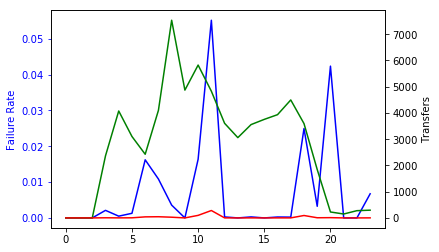

('MWT2_DATADISK', 'BNL-OSG2_DATADISK')


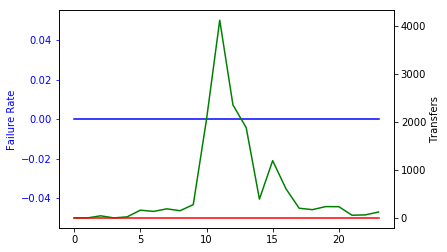

('MWT2_DATADISK', 'AGLT2_DATADISK')


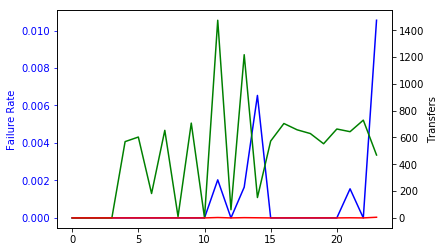

('CERN-PROD_DATADISK', 'UAM-LCG2_DATADISK')


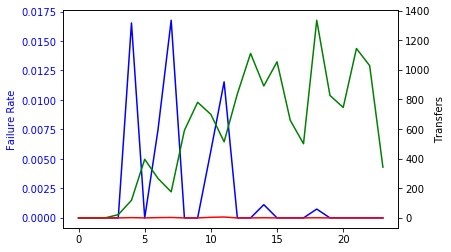

('MWT2_DATADISK', 'UKI-LT2-QMUL_DATADISK')


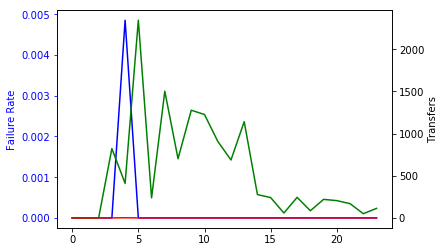

('CERN-PROD_DATADISK', 'IN2P3-CC_DATADISK')


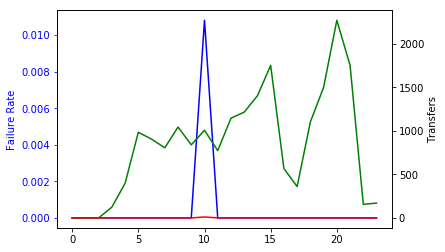

('BNL-OSG2_DATADISK', 'AGLT2_DATADISK')


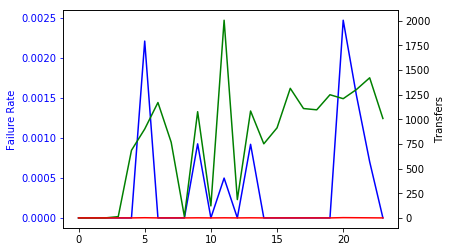

('CERN-PROD_DATADISK', 'BNL-OSG2_DATADISK')


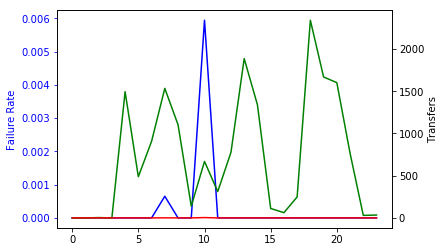

('CERN-PROD_DATADISK', 'AGLT2_DATADISK')


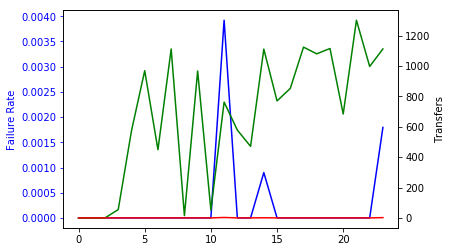

('PIC_DATADISK', 'BNL-OSG2_DATADISK')


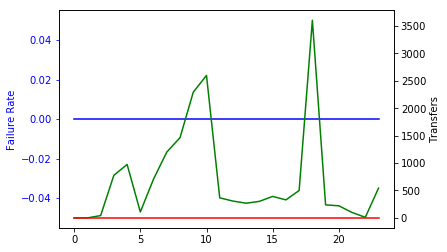

('INFN-T1_DATADISK', 'FZK-LCG2_DATADISK')


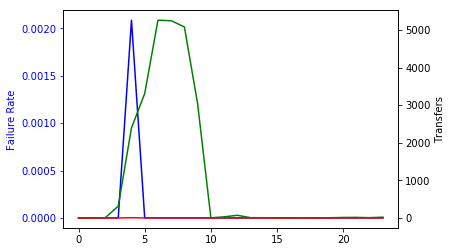

('CERN-PROD_DATADISK', 'UKI-NORTHGRID-LANCS-HEP_DATADISK')


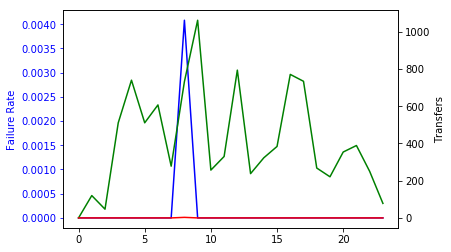

('PIC_DATADISK', 'DESY-HH_DATADISK')


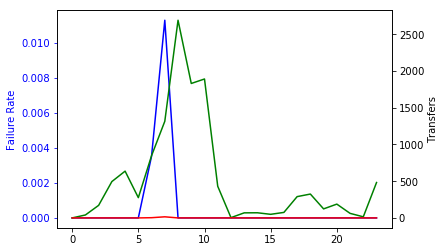

('CERN-PROD_DATADISK', 'PIC_DATADISK')


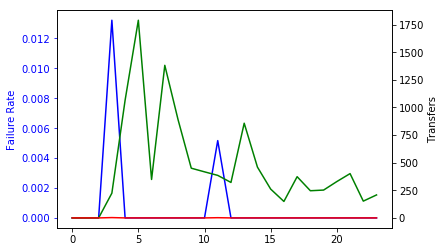

('AGLT2_DATADISK', 'CA-SCINET-T2_DATADISK')


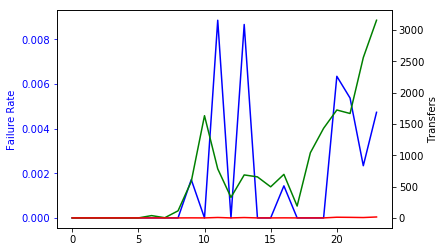

('NDGF-T1_DATADISK', 'AGLT2_DATADISK')


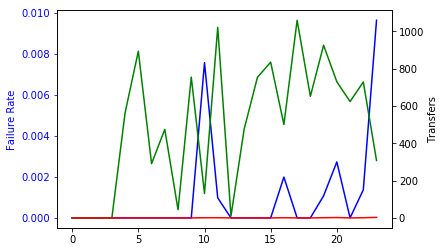

('MWT2_DATADISK', 'INFN-NAPOLI-ATLAS_DATADISK')


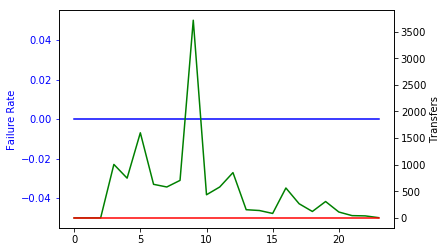

('CERN-PROD_DATADISK', 'NDGF-T1_DATADISK')


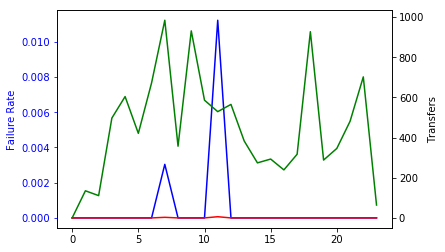

('PIC_DATADISK', 'UKI-LT2-QMUL_DATADISK')


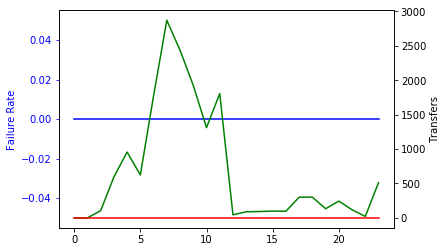

('CERN-PROD_SCRATCHDISK', 'IN2P3-CC_PHYS-HIGGS')


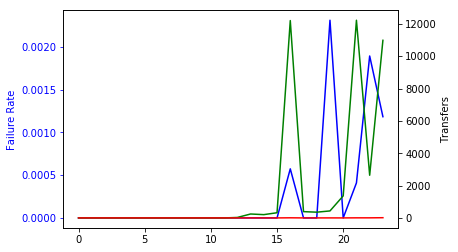

In [7]:
#plotting

for entry in rate:
    
    print(entry)
    
    fig, ax = plt.subplots()

    # Twin the x-axis to make independent y-axes.
    axes = [ax, ax.twinx()]
    
    colors = ('Green', 'Red', 'Blue')
    #for ax, color in zip(axes, colors):
    #data = np.random.random(1) * np.random.random(10)
    axes[0].plot(rate[entry], color='Blue')
    axes[0].set_ylabel('Failure Rate', color='Blue')
    axes[0].tick_params(axis='y', colors='Blue')
    
    axes[1].plot(plottransfers[entry],color='Green')
    axes[1].set_ylabel('Transfers', color='Black')
    axes[1].tick_params(axis='y', colors='Black')
    
    axes[1].plot(ploterrors[entry],color='Red')
    #axes.set_xlabel('X-axis')
    
    plt.show()
    
    #plt.plot(rate[entry])
    #plt.show()


#plt.show()

In [8]:
#number of queued transfers at any one time



('CERN-PROD_TZDISK', 'CERN-PROD_DATADISK')


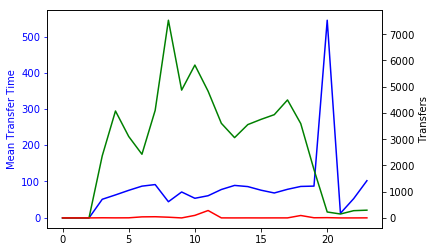

('MWT2_DATADISK', 'BNL-OSG2_DATADISK')


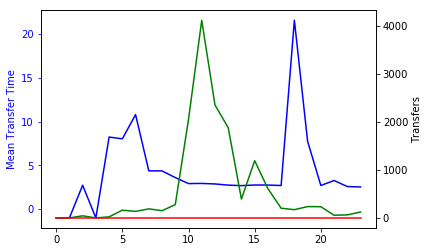

('MWT2_DATADISK', 'AGLT2_DATADISK')


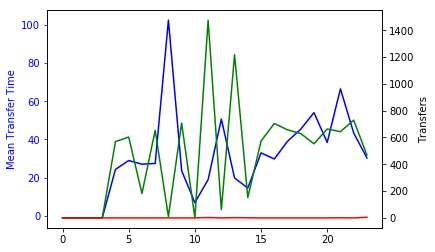

('CERN-PROD_DATADISK', 'UAM-LCG2_DATADISK')


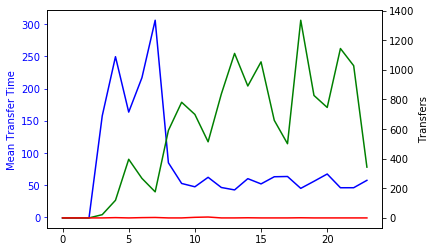

('MWT2_DATADISK', 'UKI-LT2-QMUL_DATADISK')


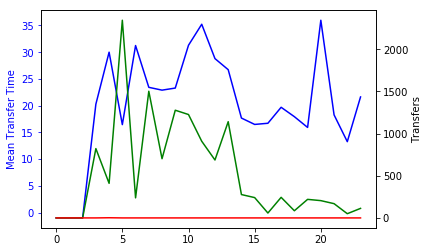

('CERN-PROD_DATADISK', 'IN2P3-CC_DATADISK')


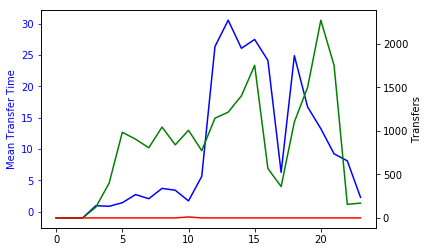

('MWT2_DATADISK', 'INFN-NAPOLI-ATLAS_DATADISK')


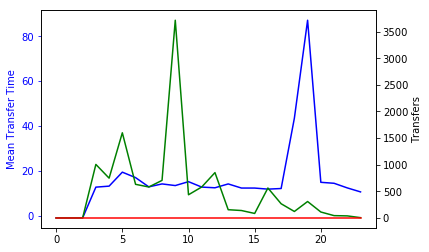

('BNL-OSG2_DATADISK', 'AGLT2_DATADISK')


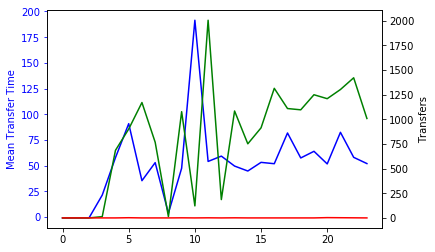

('CERN-PROD_DATADISK', 'BNL-OSG2_DATADISK')


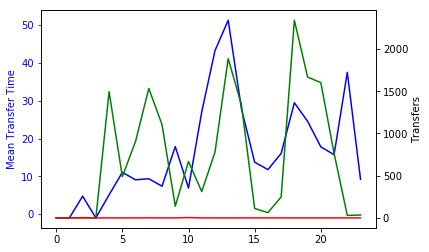

('CERN-PROD_DATADISK', 'AGLT2_DATADISK')


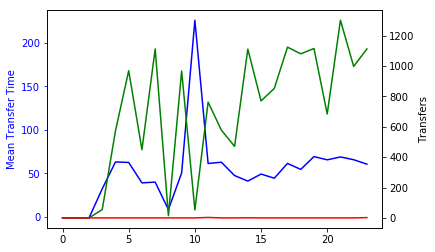

('PIC_DATADISK', 'BNL-OSG2_DATADISK')


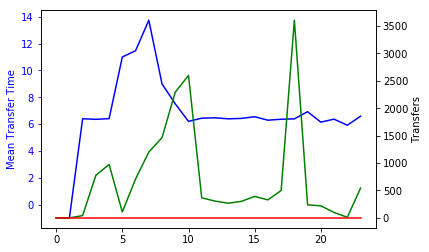

('INFN-T1_DATADISK', 'FZK-LCG2_DATADISK')


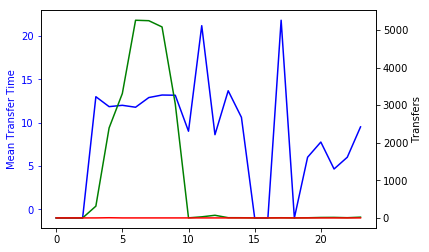

('CERN-PROD_DATADISK', 'UKI-NORTHGRID-LANCS-HEP_DATADISK')


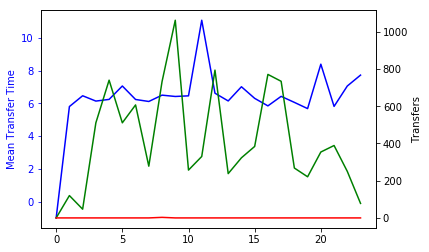

('CERN-PROD_DATADISK', 'NDGF-T1_DATADISK')


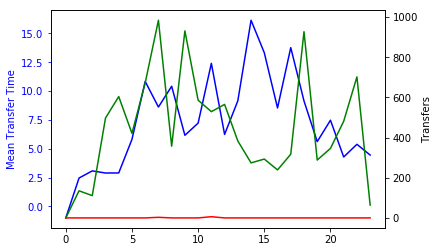

('AGLT2_DATADISK', 'CA-SCINET-T2_DATADISK')


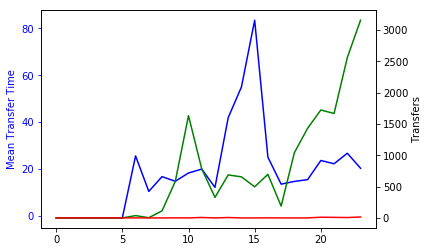

('NDGF-T1_DATADISK', 'AGLT2_DATADISK')


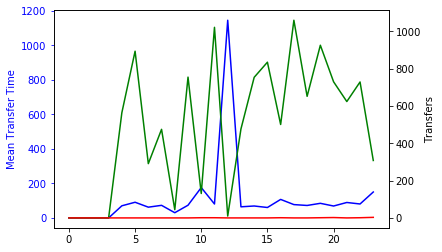

('CERN-PROD_DATADISK', 'PIC_DATADISK')


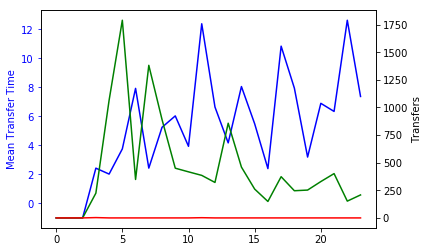

('CERN-PROD_SCRATCHDISK', 'IN2P3-CC_PHYS-HIGGS')


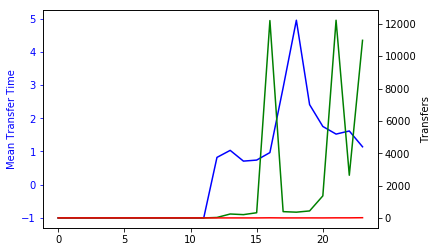

('PIC_DATADISK', 'UKI-LT2-QMUL_DATADISK')


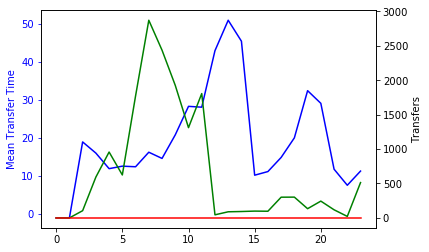

('PIC_DATADISK', 'DESY-HH_DATADISK')


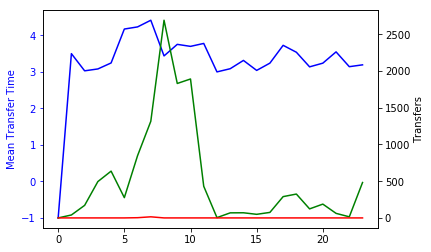

In [9]:
#Transfer time

#in each time interval, for the 20 greatest sites, plot the mean transfer time of successful transfers

for entry in plotdurations:
    
    print(entry)
    
    fig, ax = plt.subplots()

    # Twin the x-axis to make independent y-axes.
    axes = [ax, ax.twinx()]
    
    colors = ('Green', 'Red', 'Blue')
    #for ax, color in zip(axes, colors):
    #data = np.random.random(1) * np.random.random(10)
    axes[0].plot(plotdurations[entry], color='Blue')
    axes[0].set_ylabel('Mean Transfer Time', color='Blue')
    axes[0].tick_params(axis='y', colors='Blue')
    
    axes[1].plot(plottransfers[entry],color='Green')
    axes[1].set_ylabel('Transfers', color='Black')
    axes[1].tick_params(axis='y', colors='Black')
    
    axes[1].plot(ploterrors[entry],color='Red')
    
    plt.show()